<a href="https://colab.research.google.com/github/BeverlyHuang/Netflix-Movie-recommendation/blob/master/Movie_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation

This project aims to create a recommendation system for Netflix based on historical review data of users to each movie. Surprise package in Python will be applied for model building and evaluation.

#Ingestion

##Import Packages

In [0]:
!pip install -q scikit-surprise

    100% |████████████████████████████████| 3.3MB 5.7MB/s 


In [0]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
from surprise.model_selection import cross_validate, GridSearchCV
sns.set_style("darkgrid")

## Load Data

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
path = "/content/drive"
os.chdir(path)
os.listdir(path)
print(os.getcwd())

/content/drive


In this notebook, we only use data in the first file.

In [0]:
# Skip date
df = pd.read_csv('My Drive/Colab Notebooks/452_HW/HW7/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df['Rating'] = df['Rating'].astype(float)

print('Dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Dataset shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


#EDA

## Data Spread

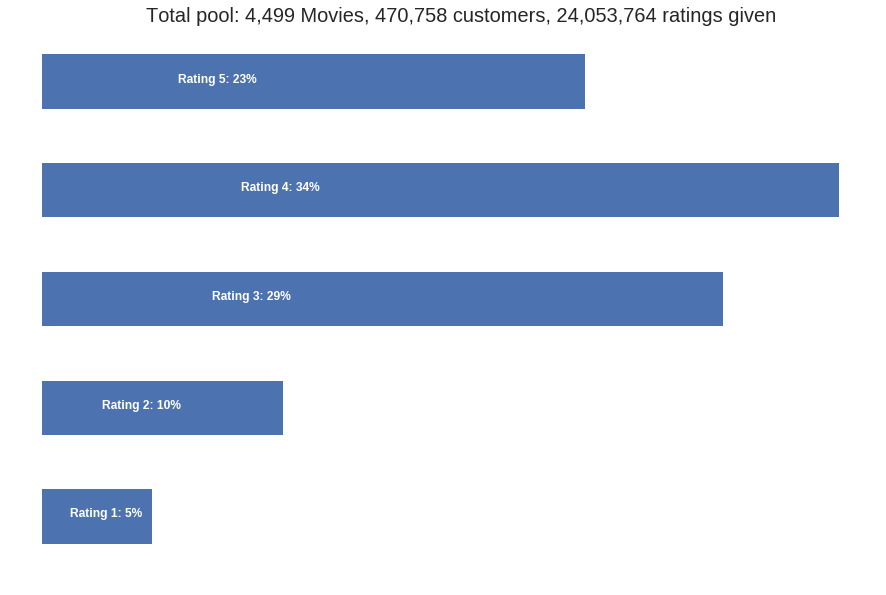

In [0]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

## Data Cleaning

In [0]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id) # Return an array filled with movie_id # the length is calculated by difference b/w two neighboring indices
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [0]:
# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])


-Dataset examples-
          Cust_Id  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


## Data Slicing

In [0]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 3884.0
Customer minimum times of review: 79.0


Now let's trim down our data, whats the difference in data size?

In [0]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (13528427, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
5109       785314     1.0         8
8889698    332300     3.0      1770
17751978   629874     4.0      3391


## Data Mapping

In [0]:
df_title = pd.read_csv('My Drive/Colab Notebooks/452_HW/HW7/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
df_title.head()

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


# Recommendation Modeling: Collaborative Filtering using SVD

##Use first 100K rows to train a default SVD model

In [0]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)

# use default SVD parameters
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9851  0.9807  0.9862  0.9840  0.0024  
MAE (testset)     0.7893  0.7884  0.8002  0.7926  0.0054  
Fit time          5.14    5.11    5.08    5.11    0.02    
Test time         0.27    0.39    0.38    0.35    0.05    


{'fit_time': (5.137081623077393, 5.112550497055054, 5.079605340957642),
 'test_mae': array([0.78926611, 0.78843621, 0.80021854]),
 'test_rmse': array([0.98513252, 0.98070832, 0.98619524]),
 'test_time': (0.2711958885192871, 0.38899970054626465, 0.37882256507873535)}

##Grid Search for the best SVD model

In [0]:
param_grid = {'n_epochs': [10, 30], 'lr_all': [0.003, 0.01],
              'reg_all': [0.3, 0.8]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9776653775706298
{'n_epochs': 30, 'lr_all': 0.003, 'reg_all': 0.3}


##Evaluate the best model

In [0]:
# use grid search best parameters
svd = SVD(n_epochs=30, lr_all=0.003, reg_all=0.3)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9745  0.9763  0.9818  0.9775  0.0031  
MAE (testset)     0.7952  0.7918  0.7990  0.7953  0.0029  
Fit time          7.67    7.46    7.51    7.55    0.09    
Test time         0.27    0.27    0.45    0.33    0.09    


{'fit_time': (7.672273874282837, 7.460507869720459, 7.507782459259033),
 'test_mae': array([0.79515248, 0.79177142, 0.79898989]),
 'test_rmse': array([0.9744905, 0.9762874, 0.9817701]),
 'test_time': (0.2675623893737793, 0.2650718688964844, 0.447843074798584)}

##Use user 783514 as an example

###What user 783514 liked in the past

In [0]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
df_785314

Movie_Id
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443                             Like Water for Chocolate
2452        Lord of the Rings: The Fellowship of the Ring
2465 

###What user 785314 would love to watch in the future

In [0]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.train(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


        Year                                           Name  Estimate_Score
3455  2004.0                                 Lost: Season 1        4.218485
2101  1994.0                         The Simpsons: Season 6        4.174444
2113  2002.0                                        Firefly        4.147903
3443  2004.0          Family Guy: Freakin' Sweet Collection        4.136795
4426  2001.0                        The West Wing: Season 3        4.124322
1475  2004.0                       Six Feet Under: Season 4        4.098810
4352  2002.0                 Curb Your Enthusiasm: Season 3        4.051611
3045  1990.0              The Simpsons: Treehouse of Horror        4.049617
2451  2001.0  Lord of the Rings: The Fellowship of the Ring        4.007420
4114  1999.0                        The Simpsons: Bart Wars        4.004292


#Conclusion

This project uses Netflix movie review data as an example to illustrate the process of recommendation modeling. Collaborative filtering model is created using SVD algorithm, and parameters for SVD are chosen from GridSearch. We then can use the final model to recommend Top 10 movies for any user.